# SuperFast SuperTrend

## Fetch and save data

In [1]:
import vectorbtpro as vbt

vbt.settings.set_theme('dark')

In [19]:
# data = vbt.BinanceData.fetch(
#     ['BTCUSDT', 'ETHUSDT'], 
#     start='2020-01-01 UTC',
#     end='2022-01-01 UTC',
#     timeframe='1h'
# )

In [21]:
# data.to_hdf('my_data.h5')

## Load data

In [22]:
data = vbt.HDFData.fetch('my_data.h5')

  0%|          | 0/2 [00:00<?, ?it/s]

In [23]:
data.data['BTCUSDT'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17513 entries, 2020-01-01 00:00:00+00:00 to 2021-12-31 23:00:00+00:00
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                17513 non-null  float64
 1   High                17513 non-null  float64
 2   Low                 17513 non-null  float64
 3   Close               17513 non-null  float64
 4   Volume              17513 non-null  float64
 5   Quote volume        17513 non-null  float64
 6   Trade count         17513 non-null  int64  
 7   Taker base volume   17513 non-null  float64
 8   Taker quote volume  17513 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.3 MB


In [24]:
data.stats()

Start                   2020-01-01 00:00:00+00:00
End                     2021-12-31 23:00:00+00:00
Period                                      17513
Total Symbols                                   2
Last Index: BTCUSDT     2021-12-31 23:00:00+00:00
Last Index: ETHUSDT     2021-12-31 23:00:00+00:00
Null Counts: BTCUSDT                            0
Null Counts: ETHUSDT                            0
Name: agg_stats, dtype: object

In [25]:
high = data.get('High')
low = data.get('Low')
close = data.get('Close')

In [26]:
print(close)

symbol                      BTCUSDT  ETHUSDT
Open time                                   
2020-01-01 00:00:00+00:00   7177.02   128.87
2020-01-01 01:00:00+00:00   7216.27   130.64
2020-01-01 02:00:00+00:00   7242.85   130.85
2020-01-01 03:00:00+00:00   7225.01   130.20
2020-01-01 04:00:00+00:00   7217.27   130.20
...                             ...      ...
2021-12-31 19:00:00+00:00  45728.28  3626.27
2021-12-31 20:00:00+00:00  45879.24  3645.04
2021-12-31 21:00:00+00:00  46333.86  3688.41
2021-12-31 22:00:00+00:00  46303.99  3681.80
2021-12-31 23:00:00+00:00  46216.93  3676.23

[17513 rows x 2 columns]


## Design

### Pandas

In [27]:
import pandas as pd
import numpy as np

In [28]:
def get_med_price(high, low):
    return (high + low) / 2

In [29]:
def get_atr(high, low, close, period):
    tr0 = abs(high - low)
    tr1 = abs(high - close.shift())
    tr2 = abs(low - close.shift())
    tr = pd.concat((tr0, tr1, tr2), axis=1).max(axis=1)
    atr = tr.ewm(alpha=1 / period, adjust=False, min_periods=period).mean()
    return atr

In [30]:
def get_basic_bands(med_price, atr, multiplier):
    matr = multiplier * atr
    upper = med_price + matr
    lower = med_price - matr
    return upper, lower

In [31]:
def get_final_bands(close, upper, lower):
    trend = pd.Series(np.full(close.shape, np.nan), index=close.index)
    dir_ = pd.Series(np.full(close.shape, 1), index=close.index)
    long = pd.Series(np.full(close.shape, np.nan), index=close.index)
    short = pd.Series(np.full(close.shape, np.nan), index=close.index)

    for i in range(1, close.shape[0]):
        if close.iloc[i] > upper.iloc[i - 1]:
            dir_.iloc[i] = 1
        elif close.iloc[i] < lower.iloc[i - 1]:
            dir_.iloc[i] = -1
        else:
            dir_.iloc[i] = dir_.iloc[i - 1]
            if dir_.iloc[i] > 0 and lower.iloc[i] < lower.iloc[i - 1]:
                lower.iloc[i] = lower.iloc[i - 1]
            if dir_.iloc[i] < 0 and upper.iloc[i] > upper.iloc[i - 1]:
                upper.iloc[i] = upper.iloc[i - 1]

        if dir_.iloc[i] > 0:
            trend.iloc[i] = long.iloc[i] = lower.iloc[i]
        else:
            trend.iloc[i] = short.iloc[i] = upper.iloc[i]
            
    return trend, dir_, long, short

In [32]:
def supertrend(high, low, close, period=7, multiplier=3):
    med_price = get_med_price(high, low)
    atr = get_atr(high, low, close, period)
    upper, lower = get_basic_bands(med_price, atr, multiplier)
    return get_final_bands(close, upper, lower)

In [33]:
supert, superd, superl, supers = supertrend(
    high['BTCUSDT'], 
    low['BTCUSDT'], 
    close['BTCUSDT']
)

In [34]:
supert

Open time
2020-01-01 00:00:00+00:00             NaN
2020-01-01 01:00:00+00:00             NaN
2020-01-01 02:00:00+00:00             NaN
2020-01-01 03:00:00+00:00             NaN
2020-01-01 04:00:00+00:00             NaN
                                 ...     
2021-12-31 19:00:00+00:00    47858.398491
2021-12-31 20:00:00+00:00    47608.346563
2021-12-31 21:00:00+00:00    47608.346563
2021-12-31 22:00:00+00:00    47608.346563
2021-12-31 23:00:00+00:00    47608.346563
Length: 17513, dtype: float64

In [35]:
superd

Open time
2020-01-01 00:00:00+00:00    1
2020-01-01 01:00:00+00:00    1
2020-01-01 02:00:00+00:00    1
2020-01-01 03:00:00+00:00    1
2020-01-01 04:00:00+00:00    1
                            ..
2021-12-31 19:00:00+00:00   -1
2021-12-31 20:00:00+00:00   -1
2021-12-31 21:00:00+00:00   -1
2021-12-31 22:00:00+00:00   -1
2021-12-31 23:00:00+00:00   -1
Length: 17513, dtype: int64

In [36]:
superl

Open time
2020-01-01 00:00:00+00:00   NaN
2020-01-01 01:00:00+00:00   NaN
2020-01-01 02:00:00+00:00   NaN
2020-01-01 03:00:00+00:00   NaN
2020-01-01 04:00:00+00:00   NaN
                             ..
2021-12-31 19:00:00+00:00   NaN
2021-12-31 20:00:00+00:00   NaN
2021-12-31 21:00:00+00:00   NaN
2021-12-31 22:00:00+00:00   NaN
2021-12-31 23:00:00+00:00   NaN
Length: 17513, dtype: float64

In [37]:
supers

Open time
2020-01-01 00:00:00+00:00             NaN
2020-01-01 01:00:00+00:00             NaN
2020-01-01 02:00:00+00:00             NaN
2020-01-01 03:00:00+00:00             NaN
2020-01-01 04:00:00+00:00             NaN
                                 ...     
2021-12-31 19:00:00+00:00    47858.398491
2021-12-31 20:00:00+00:00    47608.346563
2021-12-31 21:00:00+00:00    47608.346563
2021-12-31 22:00:00+00:00    47608.346563
2021-12-31 23:00:00+00:00    47608.346563
Length: 17513, dtype: float64

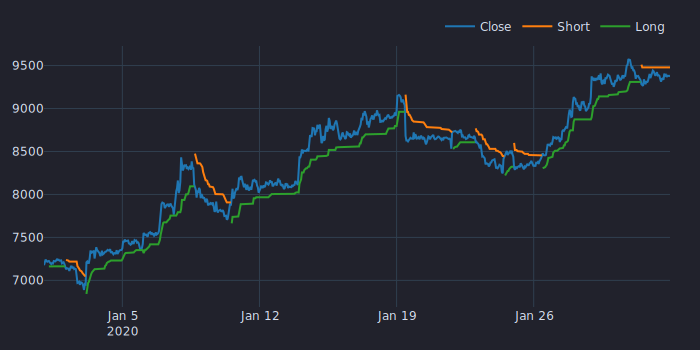

In [39]:
date_range = slice('2020-01-01', '2020-02-01')
fig = close.loc[date_range, 'BTCUSDT'].rename('Close').vbt.plot()
supers.loc[date_range].rename('Short').vbt.plot(fig=fig)
superl.loc[date_range].rename('Long').vbt.plot(fig=fig).show_svg()

In [24]:
%%timeit
supertrend(high['BTCUSDT'], low['BTCUSDT'], close['BTCUSDT'])

1.71 s ± 8.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
SUPERTREND = vbt.pandas_ta('SUPERTREND')

In [27]:
%%timeit
SUPERTREND.run(high['BTCUSDT'], low['BTCUSDT'], close['BTCUSDT'])

696 ms ± 5.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### NumPy + Numba

In [41]:
def get_atr(high, low, close, period):
    shifted_close = vbt.nb.fshift_1d_nb(close)
    tr0 = np.abs(high - low)
    tr1 = np.abs(high - shifted_close)
    tr2 = np.abs(low - shifted_close)
    tr = np.column_stack((tr0, tr1, tr2)).max(axis=1)
    atr = vbt.nb.wwm_mean_1d_nb(tr, period)
    return atr

In [42]:
from numba import njit

@njit
def get_final_bands_nb(close, upper, lower):
    trend = np.full(close.shape, np.nan)
    dir_ = np.full(close.shape, 1)
    long = np.full(close.shape, np.nan)
    short = np.full(close.shape, np.nan)

    for i in range(1, close.shape[0]):
        if close[i] > upper[i - 1]:
            dir_[i] = 1
        elif close[i] < lower[i - 1]:
            dir_[i] = -1
        else:
            dir_[i] = dir_[i - 1]
            if dir_[i] > 0 and lower[i] < lower[i - 1]:
                lower[i] = lower[i - 1]
            if dir_[i] < 0 and upper[i] > upper[i - 1]:
                upper[i] = upper[i - 1]

        if dir_[i] > 0:
            trend[i] = long[i] = lower[i]
        else:
            trend[i] = short[i] = upper[i]
            
    return trend, dir_, long, short

In [43]:
def faster_supertrend(high, low, close, period=7, multiplier=3):
    med_price = get_med_price(high, low)
    atr = get_atr(high, low, close, period)
    upper, lower = get_basic_bands(med_price, atr, multiplier)
    return get_final_bands_nb(close, upper, lower)

In [44]:
supert, superd, superl, supers = faster_supertrend(
    high['BTCUSDT'].values, 
    low['BTCUSDT'].values, 
    close['BTCUSDT'].values
)

In [47]:
supert

array([          nan,           nan,           nan, ..., 47608.3465635,
       47608.3465635, 47608.3465635])

In [48]:
superd

array([ 1,  1,  1, ..., -1, -1, -1])

In [49]:
superl

array([nan, nan, nan, ..., nan, nan, nan])

In [50]:
supers

array([          nan,           nan,           nan, ..., 47608.3465635,
       47608.3465635, 47608.3465635])

In [52]:
pd.Series(supert, index=close.index)

Open time
2020-01-01 00:00:00+00:00             NaN
2020-01-01 01:00:00+00:00             NaN
2020-01-01 02:00:00+00:00             NaN
2020-01-01 03:00:00+00:00             NaN
2020-01-01 04:00:00+00:00             NaN
                                 ...     
2021-12-31 19:00:00+00:00    47858.398491
2021-12-31 20:00:00+00:00    47608.346563
2021-12-31 21:00:00+00:00    47608.346563
2021-12-31 22:00:00+00:00    47608.346563
2021-12-31 23:00:00+00:00    47608.346563
Length: 17513, dtype: float64

In [37]:
%%timeit
faster_supertrend(
    high['BTCUSDT'].values, 
    low['BTCUSDT'].values,
    close['BTCUSDT'].values
)

1.07 ms ± 12.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### NumPy + Numba + TA-Lib

In [53]:
import talib

def faster_supertrend_talib(high, low, close, period=7, multiplier=3):
    avg_price = talib.MEDPRICE(high, low)
    atr = talib.ATR(high, low, close, period)
    upper, lower = get_basic_bands(avg_price, atr, multiplier)
    return get_final_bands_nb(close, upper, lower)

In [54]:
faster_supertrend_talib(
    high['BTCUSDT'].values, 
    low['BTCUSDT'].values, 
    close['BTCUSDT'].values
)

(array([          nan,           nan,           nan, ..., 47608.3465635,
        47608.3465635, 47608.3465635]),
 array([ 1,  1,  1, ..., -1, -1, -1]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([          nan,           nan,           nan, ..., 47608.3465635,
        47608.3465635, 47608.3465635]))

In [40]:
%%timeit
faster_supertrend_talib(
    high['BTCUSDT'].values, 
    low['BTCUSDT'].values, 
    close['BTCUSDT'].values
)

204 µs ± 1.55 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Indicator factory

In [57]:
SuperTrend = vbt.IF(
    class_name='SuperTrend',
    short_name='st',
    input_names=['high', 'low', 'close'],
    param_names=['period', 'multiplier'],
    output_names=['supert', 'superd', 'superl', 'supers']
).with_apply_func(
    faster_supertrend_talib, 
    takes_1d=True,
    period=7, 
    multiplier=3
)

In [58]:
help(SuperTrend.run)

Help on method run:

run(high, low, close, period=Default(value=7), multiplier=Default(value=3), short_name='st', hide_params=None, hide_default=True, **kwargs) method of vectorbtpro.generic.analyzable.MetaAnalyzable instance
    Run `SuperTrend` indicator.
    
    * Inputs: `high`, `low`, `close`
    * Parameters: `period`, `multiplier`
    * Outputs: `supert`, `superd`, `superl`, `supers`
    
    Pass a list of parameter names as `hide_params` to hide their column levels.
    Set `hide_default` to False to show the column levels of the parameters with a default value.
    
    Other keyword arguments are passed to `vectorbtpro.indicators.factory.run_pipeline`.



In [59]:
st = SuperTrend.run(high, low, close)
print(st.supert)

symbol                          BTCUSDT      ETHUSDT
Open time                                           
2020-01-01 00:00:00+00:00           NaN          NaN
2020-01-01 01:00:00+00:00           NaN          NaN
2020-01-01 02:00:00+00:00           NaN          NaN
2020-01-01 03:00:00+00:00           NaN          NaN
2020-01-01 04:00:00+00:00           NaN          NaN
...                                 ...          ...
2021-12-31 19:00:00+00:00  47858.398491  3792.049621
2021-12-31 20:00:00+00:00  47608.346563  3770.258246
2021-12-31 21:00:00+00:00  47608.346563  3770.258246
2021-12-31 22:00:00+00:00  47608.346563  3770.258246
2021-12-31 23:00:00+00:00  47608.346563  3770.258246

[17513 rows x 2 columns]


In [44]:
%%timeit
SuperTrend.run(high, low, close)

1.73 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Using expressions

In [60]:
expr = """
SuperTrend[st]:
medprice = @talib_medprice(high, low)
atr = @talib_atr(high, low, close, @p_period)
upper, lower = get_basic_bands(medprice, atr, @p_multiplier)
supert, superd, superl, supers = get_final_bands(close, upper, lower)
supert, superd, superl, supers
"""

In [61]:
SuperTrend = vbt.IF.from_expr(
    expr, 
    takes_1d=True,
    get_basic_bands=get_basic_bands,
    get_final_bands=get_final_bands_nb,
    period=7, 
    multiplier=3
)

In [62]:
st = SuperTrend.run(high, low, close)
print(st.supert)

symbol                          BTCUSDT      ETHUSDT
Open time                                           
2020-01-01 00:00:00+00:00           NaN          NaN
2020-01-01 01:00:00+00:00           NaN          NaN
2020-01-01 02:00:00+00:00           NaN          NaN
2020-01-01 03:00:00+00:00           NaN          NaN
2020-01-01 04:00:00+00:00           NaN          NaN
...                                 ...          ...
2021-12-31 19:00:00+00:00  47858.398491  3792.049621
2021-12-31 20:00:00+00:00  47608.346563  3770.258246
2021-12-31 21:00:00+00:00  47608.346563  3770.258246
2021-12-31 22:00:00+00:00  47608.346563  3770.258246
2021-12-31 23:00:00+00:00  47608.346563  3770.258246

[17513 rows x 2 columns]


In [48]:
%%timeit
SuperTrend.run(high, low, close)

4.91 ms ± 282 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Plot indicator

In [63]:
class SuperTrend(SuperTrend):
    def plot(self, 
             column=None, 
             close_kwargs=None,
             superl_kwargs=None,
             supers_kwargs=None,
             fig=None, 
             **layout_kwargs):
        close_kwargs = close_kwargs if close_kwargs else {}
        superl_kwargs = superl_kwargs if superl_kwargs else {}
        supers_kwargs = supers_kwargs if supers_kwargs else {}
        
        close = self.select_col_from_obj(self.close, column).rename('Close')
        supers = self.select_col_from_obj(self.supers, column).rename('Short')
        superl = self.select_col_from_obj(self.superl, column).rename('Long')
        
        fig = close.vbt.plot(fig=fig, **close_kwargs, **layout_kwargs)
        supers.vbt.plot(fig=fig, **supers_kwargs)
        superl.vbt.plot(fig=fig, **superl_kwargs)
        
        return fig

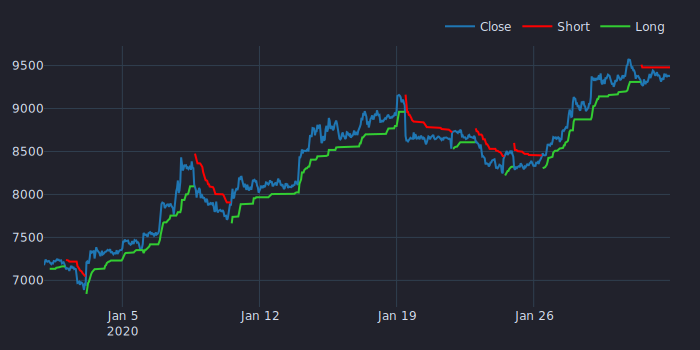

In [64]:
st = SuperTrend.run(high, low, close)
st.loc[date_range, 'BTCUSDT'].plot(
    superl_kwargs=dict(trace_kwargs=dict(line_color='limegreen')),
    supers_kwargs=dict(trace_kwargs=dict(line_color='red'))
).show_svg()

## Test indicator

In [65]:
entries = (~st.superl.isnull()).vbt.signals.fshift()
exits = (~st.supers.isnull()).vbt.signals.fshift()

In [66]:
pf = vbt.Portfolio.from_signals(
    close=close, 
    entries=entries, 
    exits=exits, 
    fees=0.001, 
    freq='1h'
)

In [67]:
pf['ETHUSDT'].stats()

Start                         2020-01-01 00:00:00+00:00
End                           2021-12-31 23:00:00+00:00
Period                                729 days 17:00:00
Start Value                                       100.0
Min Value                                     98.469385
Max Value                                   1805.987865
End Value                                   1135.272383
Total Return [%]                            1035.272383
Benchmark Return [%]                        2752.665477
Total Time Exposure [%]                       51.750128
Max Gross Exposure [%]                            100.0
Max Drawdown [%]                               37.39953
Max Drawdown Duration                  85 days 09:00:00
Total Orders                                        348
Total Fees Paid                              272.755758
Total Trades                                        174
Win Rate [%]                                  43.103448
Best Trade [%]                                33

### Optimization

In [68]:
periods = np.arange(4, 20)
multipliers = np.arange(20, 41) / 10

In [69]:
st = SuperTrend.run(
    high, low, close, 
    period=periods, 
    multiplier=multipliers,
    param_product=True,
    execute_kwargs=dict(show_progress=True)
)

  0%|          | 0/672 [00:00<?, ?it/s]

In [70]:
st.wrapper.columns

MultiIndex([( 4, 2.0, 'BTCUSDT'),
            ( 4, 2.0, 'ETHUSDT'),
            ( 4, 2.1, 'BTCUSDT'),
            ( 4, 2.1, 'ETHUSDT'),
            ( 4, 2.2, 'BTCUSDT'),
            ( 4, 2.2, 'ETHUSDT'),
            ( 4, 2.3, 'BTCUSDT'),
            ( 4, 2.3, 'ETHUSDT'),
            ( 4, 2.4, 'BTCUSDT'),
            ( 4, 2.4, 'ETHUSDT'),
            ...
            (19, 3.6, 'BTCUSDT'),
            (19, 3.6, 'ETHUSDT'),
            (19, 3.7, 'BTCUSDT'),
            (19, 3.7, 'ETHUSDT'),
            (19, 3.8, 'BTCUSDT'),
            (19, 3.8, 'ETHUSDT'),
            (19, 3.9, 'BTCUSDT'),
            (19, 3.9, 'ETHUSDT'),
            (19, 4.0, 'BTCUSDT'),
            (19, 4.0, 'ETHUSDT')],
           names=['st_period', 'st_multiplier', 'symbol'], length=672)

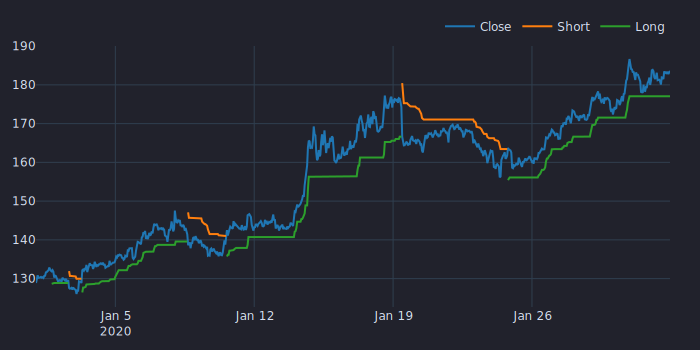

In [71]:
st.loc[date_range, (19, 4, 'ETHUSDT')].plot().show_svg()

In [72]:
print(st.getsize())

377.6 MB


In [73]:
input_size = st.wrapper.shape[0] * st.wrapper.shape[1]
n_outputs = 4
data_type_size = 8
input_size * n_outputs * data_type_size / 1024 / 1024

359.1533203125

In [74]:
entries = (~st.superl.isnull()).vbt.signals.fshift()
exits = (~st.supers.isnull()).vbt.signals.fshift()

In [75]:
pf = vbt.Portfolio.from_signals(close, entries, exits, fees=0.001, freq='1h')

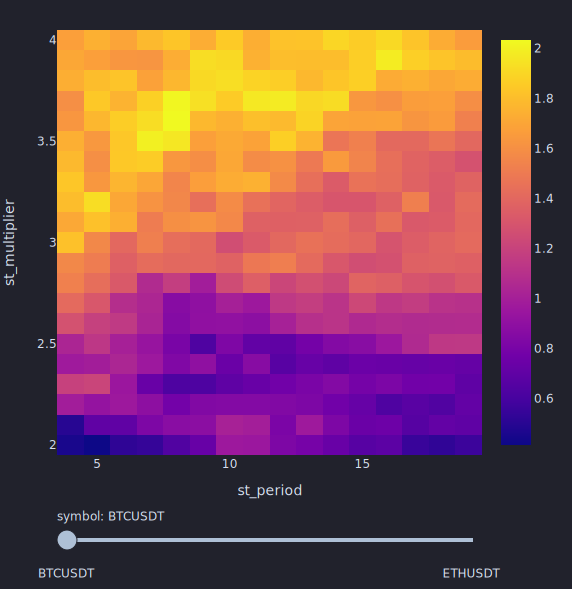

In [77]:
pf.sharpe_ratio.vbt.heatmap(
    x_level='st_period', 
    y_level='st_multiplier',
    slider_level='symbol'
).show_svg()

In [78]:
vbt.Portfolio.from_holding(close, freq='1h').sharpe_ratio

symbol
BTCUSDT    1.561447
ETHUSDT    2.170813
Name: sharpe_ratio, dtype: float64

## Streaming

In [79]:
class SuperTrendAIS(vbt.tp.NamedTuple):
    i: int
    high: float
    low: float
    close: float
    prev_close: float
    prev_upper: float
    prev_lower: float
    prev_dir_: float
    nobs: int
    weighted_avg: float
    old_wt: float
    period: int
    multiplier: float
    
class SuperTrendAOS(vbt.tp.NamedTuple):
    nobs: int
    weighted_avg: float
    old_wt: float
    upper: float
    lower: float
    trend: float
    dir_: float
    long: float
    short: float

In [80]:
@njit(nogil=True)
def get_tr_one_nb(high, low, prev_close):
    tr0 = abs(high - low)
    tr1 = abs(high - prev_close)
    tr2 = abs(low - prev_close)
    if np.isnan(tr0) or np.isnan(tr1) or np.isnan(tr2):
        tr = np.nan
    else:
        tr = max(tr0, tr1, tr2)
    return tr

@njit(nogil=True)
def get_med_price_one_nb(high, low):
    return (high + low) / 2

@njit(nogil=True)
def get_basic_bands_one_nb(high, low, atr, multiplier):
    med_price = get_med_price_one_nb(high, low)
    matr = multiplier * atr
    upper = med_price + matr
    lower = med_price - matr
    return upper, lower
    
@njit(nogil=True)
def get_final_bands_one_nb(close, upper, lower, prev_upper, prev_lower, prev_dir_):
    if close > prev_upper:
        dir_ = 1
    elif close < prev_lower:
        dir_ = -1
    else:
        dir_ = prev_dir_
        if dir_ > 0 and lower < prev_lower:
            lower = prev_lower
        if dir_ < 0 and upper > prev_upper:
            upper = prev_upper

    if dir_ > 0:
        trend = long = lower
        short = np.nan
    else:
        trend = short = upper
        long = np.nan
    return upper, lower, trend, dir_, long, short

In [81]:
@njit(nogil=True)
def superfast_supertrend_acc_nb(in_state):
    i = in_state.i
    high = in_state.high
    low = in_state.low
    close = in_state.close
    prev_close = in_state.prev_close
    prev_upper = in_state.prev_upper
    prev_lower = in_state.prev_lower
    prev_dir_ = in_state.prev_dir_
    nobs = in_state.nobs
    weighted_avg = in_state.weighted_avg
    old_wt = in_state.old_wt
    period = in_state.period
    multiplier = in_state.multiplier
    
    tr = get_tr_one_nb(high, low, prev_close)

    alpha = vbt.nb.alpha_from_wilder_nb(period)
    ewm_mean_in_state = vbt.nb.EWMMeanAIS(
        i=i,
        value=tr,
        old_wt=old_wt,
        weighted_avg=weighted_avg,
        nobs=nobs,
        alpha=alpha,
        minp=period,
        adjust=False
    )
    ewm_mean_out_state = vbt.nb.ewm_mean_acc_nb(ewm_mean_in_state)
    atr = ewm_mean_out_state.value
    
    upper, lower = get_basic_bands_one_nb(high, low, atr, multiplier)
    
    if i == 0:
        trend, dir_, long, short = np.nan, 1, np.nan, np.nan
    else:
        upper, lower, trend, dir_, long, short = get_final_bands_one_nb(
            close, upper, lower, prev_upper, prev_lower, prev_dir_)
            
    return SuperTrendAOS(
        nobs=ewm_mean_out_state.nobs,
        weighted_avg=ewm_mean_out_state.weighted_avg,
        old_wt=ewm_mean_out_state.old_wt,
        upper=upper,
        lower=lower,
        trend=trend,
        dir_=dir_,
        long=long,
        short=short
    )

In [82]:
@njit(nogil=True)
def superfast_supertrend_nb(high, low, close, period=7, multiplier=3):
    trend = np.empty(close.shape, dtype=np.float_)
    dir_ = np.empty(close.shape, dtype=np.int_)
    long = np.empty(close.shape, dtype=np.float_)
    short = np.empty(close.shape, dtype=np.float_)
    
    if close.shape[0] == 0:
        return trend, dir_, long, short

    nobs = 0
    old_wt = 1.
    weighted_avg = np.nan
    prev_upper = np.nan
    prev_lower = np.nan

    for i in range(close.shape[0]):
        in_state = SuperTrendAIS(
            i=i,
            high=high[i],
            low=low[i],
            close=close[i],
            prev_close=close[i - 1] if i > 0 else np.nan,
            prev_upper=prev_upper,
            prev_lower=prev_lower,
            prev_dir_=dir_[i - 1] if i > 0 else 1,
            nobs=nobs,
            weighted_avg=weighted_avg,
            old_wt=old_wt,
            period=period,
            multiplier=multiplier
        )
        
        out_state = superfast_supertrend_acc_nb(in_state)
        
        nobs = out_state.nobs
        weighted_avg = out_state.weighted_avg
        old_wt = out_state.old_wt
        prev_upper = out_state.upper
        prev_lower = out_state.lower
        trend[i] = out_state.trend
        dir_[i] = out_state.dir_
        long[i] = out_state.long
        short[i] = out_state.short
        
    return trend, dir_, long, short

In [83]:
superfast_out = superfast_supertrend_nb(
    high['BTCUSDT'].values,
    low['BTCUSDT'].values,
    close['BTCUSDT'].values
)

In [84]:
faster_out = faster_supertrend(
    high['BTCUSDT'].values,
    low['BTCUSDT'].values,
    close['BTCUSDT'].values
)

In [85]:
np.testing.assert_array_equal(superfast_out[0], faster_out[0])
np.testing.assert_array_equal(superfast_out[1], faster_out[1])
np.testing.assert_array_equal(superfast_out[2], faster_out[2])
np.testing.assert_array_equal(superfast_out[3], faster_out[3])

In [72]:
%%timeit
superfast_supertrend_nb(
    high['BTCUSDT'].values, 
    low['BTCUSDT'].values, 
    close['BTCUSDT'].values
)

180 µs ± 828 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Multithreading

In [86]:
SuperTrend = vbt.IF(
    class_name='SuperTrend',
    short_name='st',
    input_names=['high', 'low', 'close'],
    param_names=['period', 'multiplier'],
    output_names=['supert', 'superd', 'superl', 'supers']
).with_apply_func(
    superfast_supertrend_nb, 
    takes_1d=True,
    jit_select_params=True,
    jit_kwargs=dict(nogil=True),
    period=7, 
    multiplier=3
)

In [74]:
%%timeit
SuperTrend.run(high, low, close)

2.54 ms ± 669 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [75]:
%%timeit
SuperTrend.run(
    high, low, close, 
    period=periods, 
    multiplier=multipliers,
    param_product=True,
    execute_kwargs=dict(show_progress=False)
)

348 ms ± 156 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [87]:
270 / 336 / 2

0.4017857142857143

In [77]:
%%timeit
SuperTrend.run(
    high, low, close, 
    period=periods, 
    multiplier=multipliers,
    param_product=True,
    execute_kwargs=dict(
        engine='dask', 
        chunk_len='auto', 
        show_progress=False
    )
)

160 ms ± 18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Pipelines

In [88]:
def pipeline(data, period=7, multiplier=3):
    high = data.get('High')
    low = data.get('Low')
    close = data.get('Close')
    st = SuperTrend.run(
        high, 
        low, 
        close, 
        period=period, 
        multiplier=multiplier
    )
    entries = (~st.superl.isnull()).vbt.signals.fshift()
    exits = (~st.supers.isnull()).vbt.signals.fshift()
    pf = vbt.Portfolio.from_signals(
        close, 
        entries=entries, 
        exits=exits, 
        fees=0.001,
        fill_returns=True,
        max_orders=0,
        freq='1h'
    )
    return pf.sharpe_ratio

In [89]:
pipeline(data)

st_period  st_multiplier  symbol 
7          3              BTCUSDT    1.521221
                          ETHUSDT    2.258501
Name: sharpe_ratio, dtype: float64

In [80]:
%%timeit
pipeline(data)

27.7 ms ± 757 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [90]:
336 * 32

10752

In [91]:
import itertools

op_tree = (itertools.product, periods, multipliers)
period_product, multiplier_product = vbt.generate_param_combs(op_tree)
period_product = np.asarray(period_product)
multiplier_product = np.asarray(multiplier_product)

In [83]:
%%timeit
pipeline(data, period_product, multiplier_product)

1.34 s ± 73.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Chunked pipeline

In [92]:
chunked_pipeline = vbt.chunked(
    size=vbt.LenSizer(arg_query='period', single_type=int),
    arg_take_spec=dict(
        data=None,
        period=vbt.ChunkSlicer(),
        multiplier=vbt.ChunkSlicer()
    ),
    merge_func=lambda x: pd.concat(x).vbt.sort_index()
)(pipeline)

In [93]:
chunked_pipeline(data)

st_period  st_multiplier  symbol 
7          3              BTCUSDT    1.521221
                          ETHUSDT    2.258501
Name: sharpe_ratio, dtype: float64

In [94]:
chunked_pipeline(
    data, 
    period_product[:4], 
    multiplier_product[:4],
    _n_chunks=2,
    _engine_kwargs=dict(show_progress=True)
)

  0%|          | 0/2 [00:00<?, ?it/s]

st_period  st_multiplier  symbol 
4          2.0            BTCUSDT    0.451699
                          ETHUSDT    1.391032
           2.1            BTCUSDT    0.495387
                          ETHUSDT    1.134741
           2.2            BTCUSDT    0.985946
                          ETHUSDT    0.955616
           2.3            BTCUSDT    1.193179
                          ETHUSDT    1.307505
Name: sharpe_ratio, dtype: float64

In [95]:
chunk_meta, funcs_args = chunked_pipeline(
    data, 
    period_product[:4], 
    multiplier_product[:4],
    _n_chunks=2,
    _return_raw_chunks=True
)

In [96]:
chunk_meta

[ChunkMeta(uuid='0882b000-52ab-4694-bb7c-341a9370937b', idx=0, start=0, end=2, indices=None),
 ChunkMeta(uuid='1d5a74d9-d517-437d-a20a-4580f601a280', idx=1, start=2, end=4, indices=None)]

In [97]:
list(funcs_args)

[(<function __main__.pipeline(data, period=7, multiplier=3)>,
  (<vectorbtpro.data.custom.HDFData at 0x7f7b30509a60>,
   array([4, 4]),
   array([2. , 2.1])),
  {}),
 (<function __main__.pipeline(data, period=7, multiplier=3)>,
  (<vectorbtpro.data.custom.HDFData at 0x7f7b30509a60>,
   array([4, 4]),
   array([2.2, 2.3])),
  {})]

In [90]:
%%timeit
chunked_pipeline(data, period_product, multiplier_product)

1.21 s ± 24.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [91]:
%%timeit
chunked_pipeline(data, period_product, multiplier_product, _chunk_len=1)

10.3 s ± 418 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Numba pipeline

In [116]:
from vectorbtpro.returns import nb as ret_nb
from vectorbtpro.portfolio import nb as pf_nb
from vectorbtpro.portfolio.enums import Direction

@njit(nogil=True)
def pipeline_nb(high, low, close, periods=np.array([7]), multipliers=np.array([3]), ann_factor=365):
    sharpe = np.empty(periods.size * close.shape[1], dtype=np.float_)
    long_entries = np.empty(close.shape, dtype=np.bool_)
    long_exits = np.empty(close.shape, dtype=np.bool_)
    group_lens = np.full(close.shape[1], 1)
    init_cash = np.asarray(100.)
    fees = np.asarray(0.001)
    k = 0
    
    for i in range(periods.size):
        for col in range(close.shape[1]):
            _, _, superl, supers = superfast_supertrend_nb(
                high[:, col], 
                low[:, col], 
                close[:, col], 
                periods[i], 
                multipliers[i]
            )
            long_entries[:, col] = vbt.nb.fshift_1d_nb(~np.isnan(superl), fill_value=False)
            long_exits[:, col] = vbt.nb.fshift_1d_nb(~np.isnan(supers), fill_value=False)
            
        sim_out = pf_nb.simulate_from_signals_nb(
            target_shape=close.shape,
            group_lens=group_lens,
            init_cash=init_cash,
            high=high,
            low=low,
            close=close,
            long_entries=long_entries,
            long_exits=long_exits,
            fees=fees,
            fill_returns=True
        )
        returns = sim_out.in_outputs.returns
        sharpe[k:k + close.shape[1]] = ret_nb.sharpe_ratio_nb(returns, ann_factor, ddof=1)
        k += close.shape[1]
        
    return sharpe

In [117]:
ann_factor = vbt.pd_acc.returns.get_ann_factor(freq='1h')

In [118]:
pipeline_nb(
    high.values, 
    low.values, 
    close.values,
    ann_factor=ann_factor
)

array([1.521221  , 2.25850084])

In [119]:
%%timeit
pipeline_nb(
    high.values, 
    low.values, 
    close.values,
    ann_factor=ann_factor
)

2.05 ms ± 24 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [120]:
def merge_func(arrs, ann_args, input_columns):
    arr = np.concatenate(arrs)
    param_index = vbt.stack_indexes((
        pd.Index(ann_args['periods']['value'], name='st_period'),
        pd.Index(ann_args['multipliers']['value'], name='st_multiplier')
    ))
    index = vbt.combine_indexes((
        param_index,
        input_columns
    ))
    return pd.Series(arr, index=index)

nb_chunked = vbt.chunked(
    size=vbt.ArraySizer(arg_query='periods', axis=0),
    arg_take_spec=dict(
        high=None,
        low=None,
        close=None,
        periods=vbt.ArraySlicer(axis=0),
        multipliers=vbt.ArraySlicer(axis=0),
        ann_factor=None
    ),
    merge_func=merge_func,
    merge_kwargs=dict(
        ann_args=vbt.Rep("ann_args")
    )
)
chunked_pipeline_nb = nb_chunked(pipeline_nb)

In [121]:
chunked_pipeline_nb(
    high.values, 
    low.values,
    close.values,
    periods=period_product[:4], 
    multipliers=multiplier_product[:4],
    ann_factor=ann_factor,
    _n_chunks=2,
    _engine_kwargs=dict(show_progress=True),
    _merge_kwargs=dict(input_columns=close.columns)
)

  0%|          | 0/2 [00:00<?, ?it/s]

st_period  st_multiplier  symbol 
4          2.0            BTCUSDT    0.451699
                          ETHUSDT    1.391032
           2.1            BTCUSDT    0.495387
                          ETHUSDT    1.134741
           2.2            BTCUSDT    0.985946
                          ETHUSDT    0.955616
           2.3            BTCUSDT    1.193179
                          ETHUSDT    1.307505
dtype: float64

In [98]:
%%timeit
chunked_pipeline_nb(
    high.values, 
    low.values, 
    close.values,
    periods=period_product, 
    multipliers=multiplier_product,
    ann_factor=ann_factor,
    _merge_kwargs=dict(input_columns=close.columns)
)

715 ms ± 20.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [99]:
%%timeit
chunked_pipeline_nb(
    high.values, 
    low.values, 
    close.values,
    periods=period_product, 
    multipliers=multiplier_product,
    ann_factor=ann_factor,
    _engine='dask',
    _merge_kwargs=dict(input_columns=close.columns)
)

152 ms ± 7.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Contextualized pipeline

#### Streaming Sharpe

In [123]:
class RollSharpeAIS(vbt.tp.NamedTuple):
    i: int
    ret: float
    pre_window_ret: float
    cumsum: float
    cumsum_sq: float
    nancnt: int
    window: int
    minp: vbt.tp.Optional[int]
    ddof: int
    ann_factor: float
    
class RollSharpeAOS(vbt.tp.NamedTuple):
    cumsum: float
    cumsum_sq: float
    nancnt: int
    value: float

@njit(nogil=True)
def rolling_sharpe_acc_nb(in_state):
    mean_in_state = vbt.nb.RollMeanAIS(
        i=in_state.i,
        value=in_state.ret,
        pre_window_value=in_state.pre_window_ret,
        cumsum=in_state.cumsum,
        nancnt=in_state.nancnt,
        window=in_state.window,
        minp=in_state.minp
    )
    mean_out_state = vbt.nb.rolling_mean_acc_nb(mean_in_state)
    
    std_in_state = vbt.nb.RollStdAIS(
        i=in_state.i,
        value=in_state.ret,
        pre_window_value=in_state.pre_window_ret,
        cumsum=in_state.cumsum,
        cumsum_sq=in_state.cumsum_sq,
        nancnt=in_state.nancnt,
        window=in_state.window,
        minp=in_state.minp,
        ddof=in_state.ddof
    )
    std_out_state = vbt.nb.rolling_std_acc_nb(std_in_state)
    
    mean = mean_out_state.value
    std = std_out_state.value
    if std == 0:
        sharpe = np.nan
    else:
        sharpe = mean / std * np.sqrt(in_state.ann_factor)
    return RollSharpeAOS(
        cumsum=std_out_state.cumsum,
        cumsum_sq=std_out_state.cumsum_sq,
        nancnt=std_out_state.nancnt,
        value=sharpe
    )

In [124]:
@njit(nogil=True)
def rolling_sharpe_ratio_nb(returns, window, minp=None, ddof=0, ann_factor=365):
    if window is None:
        window = returns.shape[0]
    if minp is None:
        minp = window
    out = np.empty(returns.shape, dtype=np.float_)
    
    if returns.shape[0] == 0:
        return out

    cumsum = 0.
    cumsum_sq = 0.
    nancnt = 0

    for i in range(returns.shape[0]):
        in_state = RollSharpeAIS(
            i=i,
            ret=returns[i],
            pre_window_ret=returns[i - window] if i - window >= 0 else np.nan,
            cumsum=cumsum,
            cumsum_sq=cumsum_sq,
            nancnt=nancnt,
            window=window,
            minp=minp,
            ddof=ddof,
            ann_factor=ann_factor
        )
        
        out_state = rolling_sharpe_acc_nb(in_state)
        
        cumsum = out_state.cumsum
        cumsum_sq = out_state.cumsum_sq
        nancnt = out_state.nancnt
        out[i] = out_state.value
        
    return out

In [125]:
returns = close['BTCUSDT'].vbt.to_returns()

In [126]:
np.testing.assert_allclose(
    rolling_sharpe_ratio_nb(
        returns=returns.values, 
        window=10, 
        ddof=1, 
        ann_factor=ann_factor),
    returns.vbt.returns(freq='1h').rolling_sharpe_ratio(10).values
)

#### Callbacks

In [127]:
class Memory(vbt.tp.NamedTuple):
    nobs: vbt.tp.Array1d
    old_wt: vbt.tp.Array1d
    weighted_avg: vbt.tp.Array1d
    prev_upper: vbt.tp.Array1d
    prev_lower: vbt.tp.Array1d
    prev_dir_: vbt.tp.Array1d
    cumsum: vbt.tp.Array1d
    cumsum_sq: vbt.tp.Array1d
    nancnt: vbt.tp.Array1d
    was_entry: vbt.tp.Array1d
    was_exit: vbt.tp.Array1d

@njit(nogil=True)
def pre_sim_func_nb(c):
    memory = Memory(
        nobs=np.full(c.target_shape[1], 0, dtype=np.int_),
        old_wt=np.full(c.target_shape[1], 1., dtype=np.float_),
        weighted_avg=np.full(c.target_shape[1], np.nan, dtype=np.float_),
        prev_upper=np.full(c.target_shape[1], np.nan, dtype=np.float_),
        prev_lower=np.full(c.target_shape[1], np.nan, dtype=np.float_),
        prev_dir_=np.full(c.target_shape[1], np.nan, dtype=np.float_),
        cumsum=np.full(c.target_shape[1], 0., dtype=np.float_),
        cumsum_sq=np.full(c.target_shape[1], 0., dtype=np.float_),
        nancnt=np.full(c.target_shape[1], 0, dtype=np.int_),
        was_entry=np.full(c.target_shape[1], False, dtype=np.bool_),
        was_exit=np.full(c.target_shape[1], False, dtype=np.bool_)
    )
    return (memory,)

In [128]:
@njit(nogil=True)
def order_func_nb(c, memory, period, multiplier):
    is_entry = memory.was_entry[c.col]
    is_exit = memory.was_exit[c.col]
    
    in_state = SuperTrendAIS(
        i=c.i,
        high=c.high[c.i, c.col],
        low=c.low[c.i, c.col],
        close=c.close[c.i, c.col],
        prev_close=c.close[c.i - 1, c.col] if c.i > 0 else np.nan,
        prev_upper=memory.prev_upper[c.col],
        prev_lower=memory.prev_lower[c.col],
        prev_dir_=memory.prev_dir_[c.col],
        nobs=memory.nobs[c.col],
        weighted_avg=memory.weighted_avg[c.col],
        old_wt=memory.old_wt[c.col],
        period=period,
        multiplier=multiplier
    )

    out_state = superfast_supertrend_acc_nb(in_state)

    memory.nobs[c.col] = out_state.nobs
    memory.weighted_avg[c.col] = out_state.weighted_avg
    memory.old_wt[c.col] = out_state.old_wt
    memory.prev_upper[c.col] = out_state.upper
    memory.prev_lower[c.col] = out_state.lower
    memory.prev_dir_[c.col] = out_state.dir_
    memory.was_entry[c.col] = not np.isnan(out_state.long)
    memory.was_exit[c.col] = not np.isnan(out_state.short)
    
    in_position = c.position_now > 0
    if is_entry and not in_position:
        size = np.inf
    elif is_exit and in_position:
        size = -np.inf
    else:
        size = 0.
    return pf_nb.order_nb(
        size=size, 
        direction=Direction.LongOnly,
        fees=0.001
    )

In [129]:
@njit(nogil=True)
def post_segment_func_nb(c, memory, ann_factor):
    for col in range(c.from_col, c.to_col):
        in_state = RollSharpeAIS(
            i=c.i,
            ret=c.last_return[col],
            pre_window_ret=np.nan,
            cumsum=memory.cumsum[col],
            cumsum_sq=memory.cumsum_sq[col],
            nancnt=memory.nancnt[col],
            window=c.i + 1,
            minp=0,
            ddof=1,
            ann_factor=ann_factor
        )
        out_state = rolling_sharpe_acc_nb(in_state)
        memory.cumsum[col] = out_state.cumsum
        memory.cumsum_sq[col] = out_state.cumsum_sq
        memory.nancnt[col] = out_state.nancnt
        c.in_outputs.sharpe[col] = out_state.value

In [130]:
class InOutputs(vbt.tp.NamedTuple):
    sharpe: vbt.tp.Array1d

@njit(nogil=True)
def ctx_pipeline_nb(high, low, close, periods=np.array([7]), multipliers=np.array([3]), ann_factor=365):
    in_outputs = InOutputs(sharpe=np.empty(close.shape[1], dtype=np.float_))
    sharpe = np.empty(periods.size * close.shape[1], dtype=np.float_)
    group_lens = np.full(close.shape[1], 1)
    call_seq = np.full(close.shape, 0)
    init_cash = np.asarray(100.)
    k = 0
    
    for i in range(periods.size):
        sim_out = pf_nb.simulate_nb(
            target_shape=close.shape,
            group_lens=group_lens,
            cash_sharing=False,
            call_seq=call_seq,
            init_cash=init_cash,
            pre_sim_func_nb=pre_sim_func_nb,
            order_func_nb=order_func_nb,
            order_args=(periods[i], multipliers[i]),
            post_segment_func_nb=post_segment_func_nb,
            post_segment_args=(ann_factor,),
            high=high,
            low=low,
            close=close,
            in_outputs=in_outputs,
            fill_pos_record=False,
            max_orders=0,
            flex_2d=True
        )
        sharpe[k:k + close.shape[1]] = in_outputs.sharpe
        k += close.shape[1]
        
    return sharpe

In [131]:
ctx_pipeline_nb(
    high.values, 
    low.values, 
    close.values,
    ann_factor=ann_factor
)

array([1.521221  , 2.25850084])

In [110]:
%%timeit
ctx_pipeline_nb(
    high.values, 
    low.values, 
    close.values,
    ann_factor=ann_factor
)

20.7 ms ± 142 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [132]:
chunked_ctx_pipeline_nb = nb_chunked(ctx_pipeline_nb)

In [133]:
chunked_ctx_pipeline_nb(
    high.values, 
    low.values,
    close.values,
    periods=period_product[:4], 
    multipliers=multiplier_product[:4],
    ann_factor=ann_factor,
    _n_chunks=2,
    _engine_kwargs=dict(show_progress=True),
    _merge_kwargs=dict(input_columns=close.columns)
)

  0%|          | 0/2 [00:00<?, ?it/s]

st_period  st_multiplier  symbol 
4          2.0            BTCUSDT    0.451699
                          ETHUSDT    1.391032
           2.1            BTCUSDT    0.495387
                          ETHUSDT    1.134741
           2.2            BTCUSDT    0.985946
                          ETHUSDT    0.955616
           2.3            BTCUSDT    1.193179
                          ETHUSDT    1.307505
dtype: float64

In [113]:
%%timeit
chunked_ctx_pipeline_nb(
    high.values, 
    low.values, 
    close.values,
    periods=period_product, 
    multipliers=multiplier_product,
    ann_factor=ann_factor,
    _merge_kwargs=dict(input_columns=close.columns)
)

6.9 s ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [114]:
%%timeit
chunked_ctx_pipeline_nb(
    high.values, 
    low.values, 
    close.values,
    periods=period_product, 
    multipliers=multiplier_product,
    ann_factor=ann_factor,
    _engine='dask',
    _merge_kwargs=dict(input_columns=close.columns)
)

1.47 s ± 126 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Bonus: Own simulator

In [134]:
from vectorbtpro.portfolio.enums import ExecState, PriceArea

@njit(nogil=True)
def raw_pipeline_nb(high, low, close, periods=np.array([7]), multipliers=np.array([3]), ann_factor=365):
    out = np.empty(periods.size * close.shape[1], dtype=np.float_)
    
    if close.shape[0] == 0:
        return out

    for k in range(len(periods)):
        
        for col in range(close.shape[1]):
            nobs = 0
            old_wt = 1.
            weighted_avg = np.nan
            prev_close_ = np.nan
            prev_upper = np.nan
            prev_lower = np.nan
            prev_dir_ = 1
            cumsum = 0.
            cumsum_sq = 0.
            nancnt = 0
            was_entry = False
            was_exit = False

            init_cash = 100.
            cash = init_cash
            position = 0.
            debt = 0.
            free_cash = init_cash
            val_price = np.nan
            value = init_cash
            prev_value = init_cash
            return_ = 0.

            for i in range(close.shape[0]):
                is_entry = was_entry
                is_exit = was_exit

                st_in_state = SuperTrendAIS(
                    i=i,
                    high=high[i, col],
                    low=low[i, col],
                    close=close[i, col],
                    prev_close=prev_close_,
                    prev_upper=prev_upper,
                    prev_lower=prev_lower,
                    prev_dir_=prev_dir_,
                    nobs=nobs,
                    weighted_avg=weighted_avg,
                    old_wt=old_wt,
                    period=periods[k],
                    multiplier=multipliers[k]
                )

                st_out_state = superfast_supertrend_acc_nb(st_in_state)

                nobs = st_out_state.nobs
                weighted_avg = st_out_state.weighted_avg
                old_wt = st_out_state.old_wt
                prev_close_ = close[i, col]
                prev_upper = st_out_state.upper
                prev_lower = st_out_state.lower
                prev_dir_ = st_out_state.dir_
                was_entry = not np.isnan(st_out_state.long)
                was_exit = not np.isnan(st_out_state.short)

                if is_entry and position == 0:
                    size = np.inf
                elif is_exit and position > 0:
                    size = -np.inf
                else:
                    size = np.nan

                val_price = close[i, col]
                value = cash + position * val_price
                if not np.isnan(size):
                    exec_state = ExecState(
                        cash=cash,
                        position=position,
                        debt=debt,
                        free_cash=free_cash,
                        val_price=val_price,
                        value=value
                    )
                    price_area = PriceArea(
                        open=np.nan,
                        high=high[i, col],
                        low=low[i, col],
                        close=close[i, col]
                    )
                    order = pf_nb.order_nb(
                        size=size, 
                        direction=Direction.LongOnly,
                        fees=0.001
                    )
                    new_exec_state, _ = pf_nb.execute_order_nb(exec_state, order, price_area)
                    cash, position, debt, free_cash, val_price, value = new_exec_state

                value = cash + position * val_price
                return_ = ret_nb.get_return_nb(prev_value, value)
                prev_value = value

                sharpe_in_state = RollSharpeAIS(
                    i=i,
                    ret=return_,
                    pre_window_ret=np.nan,
                    cumsum=cumsum,
                    cumsum_sq=cumsum_sq,
                    nancnt=nancnt,
                    window=i + 1,
                    minp=0,
                    ddof=1,
                    ann_factor=ann_factor
                )
                sharpe_out_state = rolling_sharpe_acc_nb(sharpe_in_state)
                cumsum = sharpe_out_state.cumsum
                cumsum_sq = sharpe_out_state.cumsum_sq
                nancnt = sharpe_out_state.nancnt
                sharpe = sharpe_out_state.value

            out[k * close.shape[1] + col] = sharpe
        
    return out

In [135]:
raw_pipeline_nb(
    high.values, 
    low.values, 
    close.values,
    ann_factor=ann_factor
)

array([1.521221  , 2.25850084])

In [119]:
%%timeit
raw_pipeline_nb(
    high.values, 
    low.values, 
    close.values,
    ann_factor=ann_factor
)

830 µs ± 14.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [136]:
chunked_raw_pipeline_nb = nb_chunked(raw_pipeline_nb)

In [137]:
chunked_raw_pipeline_nb(
    high.values, 
    low.values,
    close.values,
    periods=period_product[:4], 
    multipliers=multiplier_product[:4],
    ann_factor=ann_factor,
    _n_chunks=2,
    _engine_kwargs=dict(show_progress=True),
    _merge_kwargs=dict(input_columns=close.columns)
)

  0%|          | 0/2 [00:00<?, ?it/s]

st_period  st_multiplier  symbol 
4          2.0            BTCUSDT    0.451699
                          ETHUSDT    1.391032
           2.1            BTCUSDT    0.495387
                          ETHUSDT    1.134741
           2.2            BTCUSDT    0.985946
                          ETHUSDT    0.955616
           2.3            BTCUSDT    1.193179
                          ETHUSDT    1.307505
dtype: float64

In [122]:
%%timeit
chunked_raw_pipeline_nb(
    high.values, 
    low.values, 
    close.values,
    periods=period_product, 
    multipliers=multiplier_product,
    ann_factor=ann_factor,
    _merge_kwargs=dict(input_columns=close.columns)
)

242 ms ± 2.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [123]:
%%timeit
chunked_raw_pipeline_nb(
    high.values, 
    low.values, 
    close.values,
    periods=period_product, 
    multipliers=multiplier_product,
    ann_factor=ann_factor,
    _engine='dask',
    _merge_kwargs=dict(input_columns=close.columns)
)

56.7 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [138]:
range_len = int(pd.Timedelta('365d') / pd.Timedelta('1h'))

In [139]:
roll_high, range_indexes = high.vbt.range_split(range_len=range_len, n=100)
roll_low, _ = low.vbt.range_split(range_len=range_len, n=100)
roll_close, _ = close.vbt.range_split(range_len=range_len, n=100)

In [140]:
roll_close.columns

MultiIndex([( 0, 'BTCUSDT'),
            ( 0, 'ETHUSDT'),
            ( 1, 'BTCUSDT'),
            ( 1, 'ETHUSDT'),
            ( 2, 'BTCUSDT'),
            ( 2, 'ETHUSDT'),
            ( 3, 'BTCUSDT'),
            ( 3, 'ETHUSDT'),
            ( 4, 'BTCUSDT'),
            ( 4, 'ETHUSDT'),
            ...
            (95, 'BTCUSDT'),
            (95, 'ETHUSDT'),
            (96, 'BTCUSDT'),
            (96, 'ETHUSDT'),
            (97, 'BTCUSDT'),
            (97, 'ETHUSDT'),
            (98, 'BTCUSDT'),
            (98, 'ETHUSDT'),
            (99, 'BTCUSDT'),
            (99, 'ETHUSDT')],
           names=['split_idx', 'symbol'], length=200)

In [141]:
range_indexes[0]

DatetimeIndex(['2020-01-01 00:00:00+00:00', '2020-01-01 01:00:00+00:00',
               '2020-01-01 02:00:00+00:00', '2020-01-01 03:00:00+00:00',
               '2020-01-01 04:00:00+00:00', '2020-01-01 05:00:00+00:00',
               '2020-01-01 06:00:00+00:00', '2020-01-01 07:00:00+00:00',
               '2020-01-01 08:00:00+00:00', '2020-01-01 09:00:00+00:00',
               ...
               '2020-12-31 08:00:00+00:00', '2020-12-31 09:00:00+00:00',
               '2020-12-31 10:00:00+00:00', '2020-12-31 11:00:00+00:00',
               '2020-12-31 12:00:00+00:00', '2020-12-31 13:00:00+00:00',
               '2020-12-31 14:00:00+00:00', '2020-12-31 15:00:00+00:00',
               '2020-12-31 16:00:00+00:00', '2020-12-31 17:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='split_0', length=8760, freq=None)

In [142]:
sharpe_ratios = chunked_raw_pipeline_nb(
    roll_high.values, 
    roll_low.values,
    roll_close.values,
    periods=period_product, 
    multipliers=multiplier_product,
    ann_factor=ann_factor,
    _engine='dask',
    _merge_kwargs=dict(input_columns=roll_close.columns)
)

In [143]:
sharpe_ratios

st_period  st_multiplier  split_idx  symbol 
4          2.0            0          BTCUSDT    1.751331
                                     ETHUSDT    2.479750
                          1          BTCUSDT    1.847095
                                     ETHUSDT    2.736193
                          2          BTCUSDT    1.739149
                                                  ...   
19         4.0            97         ETHUSDT    1.503001
                          98         BTCUSDT    0.954932
                                     ETHUSDT    1.204134
                          99         BTCUSDT    0.818209
                                     ETHUSDT    1.191223
Length: 67200, dtype: float64

In [144]:
pf_hold = vbt.Portfolio.from_holding(roll_close, freq='1h')
sharpe_ratios_hold = pf_hold.sharpe_ratio

In [145]:
sharpe_ratios_hold

split_idx  symbol 
0          BTCUSDT    2.229122
           ETHUSDT    2.370132
1          BTCUSDT    2.298050
           ETHUSDT    2.611722
2          BTCUSDT    2.351417
                        ...   
97         ETHUSDT    2.315863
98         BTCUSDT    1.124489
           ETHUSDT    2.114297
99         BTCUSDT    0.975638
           ETHUSDT    2.008839
Name: sharpe_ratio, Length: 200, dtype: float64

In [146]:
def plot_subperiod_sharpe(index, sharpe_ratios, sharpe_ratios_hold, range_indexes, symbol):
    split_idx = index[0]
    sharpe_ratios = sharpe_ratios.xs(
        symbol, 
        level='symbol', 
        drop_level=True)
    sharpe_ratios = sharpe_ratios.xs(
        split_idx, 
        level='split_idx', 
        drop_level=True)
    start_date = range_indexes[split_idx][0]
    end_date = range_indexes[split_idx][-1]
    return sharpe_ratios.vbt.heatmap(
        x_level='st_period', 
        y_level='st_multiplier',
        title="{} - {}".format(
            start_date.strftime("%d %b, %Y %H:%M:%S"),
            end_date.strftime("%d %b, %Y %H:%M:%S")
        ),
        trace_kwargs=dict(
            zmin=sharpe_ratios.min(),
            zmid=sharpe_ratios_hold[(split_idx, symbol)],
            zmax=sharpe_ratios.max(),
            colorscale='Spectral'
        )
    )

In [147]:
fname = 'examples_raw_pipeline.gif'
level_idx = sharpe_ratios.index.names.index('split_idx')
split_indices = sharpe_ratios.index.levels[level_idx]

vbt.save_animation(
    fname,
    split_indices, 
    plot_subperiod_sharpe,
    sharpe_ratios,
    sharpe_ratios_hold,
    range_indexes,
    'BTCUSDT',
    delta=1,
    fps=7
)

  0%|          | 0/100 [00:00<?, ?it/s]

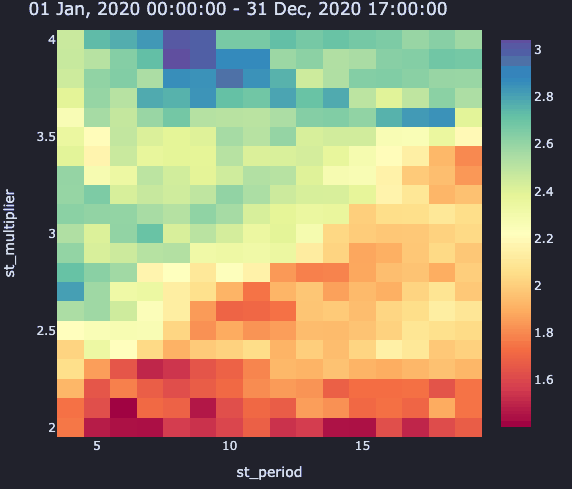

In [148]:
from IPython.display import Image, display
    
with open(fname,'rb') as f:
    display(Image(data=f.read(), format='png'))